In [1]:
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pybithumb

In [2]:
# Hyperparameters
EPISODES = 1000
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 1000
GAMMA = 0.3
LR = 0.0005
BATCH_SIZE = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

connect_key = "d5c7f4458a58322ac7573f9f8193d4f2"
secret_key = "aacd7c9c31a4bbcf30d5088a1b22e338"
bithumb = pybithumb.Bithumb(connect_key, secret_key)
reference = bithumb.get_candlestick("BTC", "KRW", "1h")
sample = bithumb.get_candlestick("ETH", "KRW", "1h")
sample.head()

,open,high,low,close,volume
time,,,,,
2020-10-22 23:00:00,462900.0,464400.0,461000.0,464400.0,2152.775366
2020-10-23 00:00:00,464300.0,467200.0,462600.0,465100.0,2874.573902
2020-10-23 01:00:00,465200.0,467900.0,464200.0,466800.0,1797.965326
2020-10-23 02:00:00,467600.0,470000.0,464600.0,467900.0,1963.532968
2020-10-23 03:00:00,467900.0,469200.0,465700.0,468600.0,422.496306


In [3]:
# preprocess
sample['rtn'] = sample['open'] / sample.shift(1)['open']
sample['ema5'] = sample['close'].ewm(span=5).mean()

ndays_high = sample['high'].rolling(window=10).max()
ndays_low = sample['low'].rolling(window=10).min()
sample['fast_k'] = (sample.close - ndays_low)/(ndays_high - ndays_low)
sample['slow_d'] = sample['fast_k'].rolling(window=3).mean()

bb = sample[['close']].copy()
bb['center'] = bb['close'].rolling(window=20).mean()
bb['upper'] = bb['center'] + 2*bb['close'].rolling(window=20).std()
bb['lower'] = bb['center'] - 2*bb['close'].rolling(window=20).std()
sample['PB'] = (bb['close'] - bb['lower'])/(bb['upper'] - bb['lower'])

sample['TP'] = (sample['high'] + sample['low'] + sample['close']) / 3
sample['PMF'] = np.nan
sample['NMF'] = np.nan
for idx in sample.index:
    if sample.loc[idx, 'TP'] > sample.shift(1).loc[idx, 'TP']:
        sample.loc[idx, 'PMF'] = sample.loc[idx, 'TP']*sample.loc[idx, 'volume']
        sample.loc[idx, 'NMF'] = 0.
    else:
        sample.loc[idx, 'NMF'] = sample.loc[idx, 'TP']*sample.loc[idx, 'volume']
        sample.loc[idx, 'PMF'] = 0.
sample['MFI'] = sample['PMF'].rolling(window=5).sum()/(sample['PMF'].rolling(window=5).sum() + sample['NMF'].rolling(window=5).sum())

sample['momentum'] = (sample['close'] - sample.shift(5)['close']) / sample.shift(5)['close']

sample['ref'] = reference['close']

sample = sample[['ema5', 'momentum', 'PB', 'MFI', 'slow_d', 'ref', 'rtn']].copy()
sample['ema5'] = sample['ema5'].pct_change() + 0.5
sample['slow_d'] = sample['slow_d'].pct_change() + 0.5
sample['ref'] = sample['ref'].pct_change() + 0.5

sample['ema5'] = sample['ema5'].shift(1)
sample['momentum'] = sample['momentum'].shift(1)
sample['PB'] = sample['PB'].shift(1)
sample['MFI'] = sample['MFI'].shift(1)
sample['slow_d'] = sample['slow_d'].shift(1)
sample['ref'] = sample['ref'].shift(1)

sample = sample.dropna()

cut = int(len(sample.index)*0.7)
train_sample = sample.iloc[:cut, :]
test_sample = sample.iloc[cut:, :]
train_sample.head()

,ema5,momentum,PB,MFI,slow_d,ref,rtn
time,,,,,,,
2020-10-23 19:00:00,0.500420,0.002802,0.461798,0.497225,0.553586,0.502555,1.003448
2020-10-23 20:00:00,0.502503,-0.000427,0.759502,0.494693,0.765040,0.504889,1.005799
2020-10-23 21:00:00,0.501807,0.006877,0.755379,0.658838,0.623288,0.497533,1.000214
2020-10-23 22:00:00,0.501345,0.011001,0.758668,0.872793,0.568559,0.499931,1.000854
2020-10-23 23:00:00,0.500254,0.008190,0.672371,0.883390,0.407755,0.500069,0.998294


In [14]:
class Gym():
    def __init__(self, sample):
        self.acc_rtn = 1.
        self.bought = False
        self.turn  = 0
        self.sample = sample.to_numpy()
    
    def reset(self):
        self.acc_rtn = 1.
        self.bought = False
        self.turn = 0
        return self.get_state()

    def step(self, action):
        actions = ['buy', 'sell']
        action = actions[action]

        # update current status
        if self.bought and action == "sell":
            self.bought = False
        elif not self.bought and action == "buy":
            self.bought = True
        else:
            pass
        
        # get state
        state = None
        done = self.is_done()
        if not done:
            state = self.get_state()

        # calculate reward
        rtn = 1.
        if self.bought and action == "buy":
            rtn = self.sample[self.turn][-1]
        elif self.bought and action == "sell":
            rtn = self.sample[self.turn][-1] - 0.004
        elif not self.bought and action == "buy":
            rtn = 1. - 0.004
        else:
            rtn = 1.

        reward = (rtn - 1.)*100
        
        self.acc_rtn *= rtn
        self.turn += 1

        return state, reward, done
    
    def get_state(self):
        return self.sample[self.turn][:6]
    
    def is_done(self):
        if self.acc_rtn <= 0.8 or self.turn == len(self.sample)-1:
            return True
        else:
            return False

In [15]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = deque(maxlen=48*21)

    def memorize(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

    def clear(self):
        self.buffer.clear()
    

In [16]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(6, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.outlayer = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.dropout(x)
        x = F.relu(self.fc4(x))
        x = F.dropout(x)
        return self.outlayer(x)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            return self.forward(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])

In [17]:
def train(q, q_target, memory, optimizer):
    if memory.size() < BATCH_SIZE:
        return
    batch = memory.sample(BATCH_SIZE)
    states, actions, rewards, next_states = zip(*batch)

    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)
    next_states = torch.cat(next_states)

    current_q = q(states).gather(1, actions)
    max_next_q = q_target(next_states).detach().max(1)[0]
    expected_q = rewards + (GAMMA*max_next_q)

    loss = F.smooth_l1_loss(current_q.squeeze(), expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [18]:
# train
print(f"Buy and Hold for train: {round(train_sample['rtn'].cumprod().iloc[-1]*100 - 100, 2)}%")

env = Gym(train_sample)
agent = Qnet().to(DEVICE)
target = Qnet().to(DEVICE)
target.load_state_dict(agent.state_dict())

memory = ReplayBuffer()
optimizer = optim.Adam(agent.parameters(), lr=LR)
score_history = []
loss_history = []

for epi in range(EPISODES):
    epsilon = max(EPS_END, EPS_END + (EPS_START - EPS_END)*np.exp(-1.*epi/EPS_DECAY))
    state = env.reset()
    memory.clear()
    loss = 0.

    while True:
        state = torch.FloatTensor([state]).to(DEVICE)
        action = agent.act(state, epsilon)
        next_state, reward, done = env.step(action.item())

        if done:
            print(f"EPISODE: {epi+1}\t RETURNS: {round(env.acc_rtn*100-100, 2)}%\t LOSS: {loss}")
            score_history.append(env.acc_rtn-1.)
            loss_history.append(loss)
            break
        else:
            transition = (state, action.to(DEVICE), torch.FloatTensor([reward]).to(DEVICE), torch.FloatTensor([next_state]).to(DEVICE))
            memory.memorize(transition)

            loss = train(agent, target, memory, optimizer)
            state = next_state
    target.load_state_dict(agent.state_dict())

torch.save(agent.state_dict(), "./models/agent.pth")

Buy and Hold for train: 260.72%
EPISODE: 1	 RETURNS: 138.43%	 LOSS: 0.2160518765449524
EPISODE: 2	 RETURNS: 200.62%	 LOSS: 0.32509392499923706
EPISODE: 3	 RETURNS: 105.03%	 LOSS: 0.20396000146865845
EPISODE: 4	 RETURNS: 45.69%	 LOSS: 0.2610871195793152
EPISODE: 5	 RETURNS: 212.87%	 LOSS: 0.24045565724372864
EPISODE: 6	 RETURNS: 7.4%	 LOSS: 0.27081066370010376
EPISODE: 7	 RETURNS: 52.36%	 LOSS: 0.27348387241363525
EPISODE: 8	 RETURNS: 27.45%	 LOSS: 0.2679530382156372
EPISODE: 9	 RETURNS: 262.2%	 LOSS: 0.41368192434310913
EPISODE: 10	 RETURNS: 35.77%	 LOSS: 0.19984565675258636
EPISODE: 11	 RETURNS: 87.68%	 LOSS: 0.3035253882408142
EPISODE: 12	 RETURNS: 151.8%	 LOSS: 0.38803771138191223
EPISODE: 13	 RETURNS: 56.15%	 LOSS: 0.24314096570014954
EPISODE: 14	 RETURNS: 91.79%	 LOSS: 0.2930397689342499
EPISODE: 15	 RETURNS: 307.09%	 LOSS: 0.28006938099861145
EPISODE: 16	 RETURNS: 112.23%	 LOSS: 0.2559921443462372
EPISODE: 17	 RETURNS: 67.3%	 LOSS: 0.1519498974084854
EPISODE: 18	 RETURNS: 63.14%	

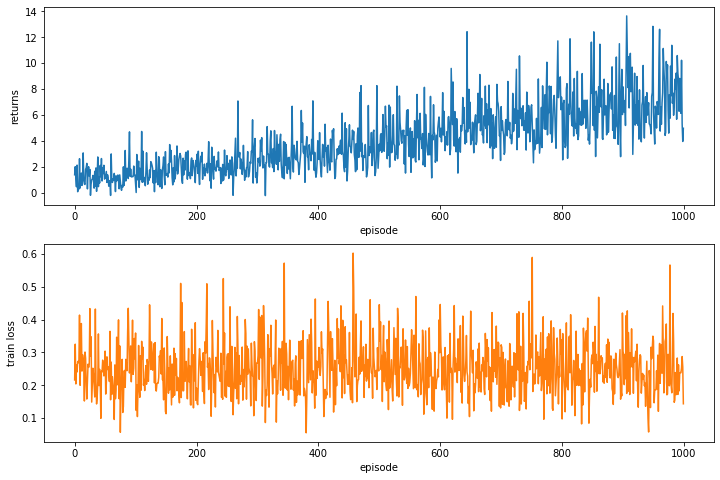

In [19]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(score_history)
plt.xlabel('episode')
plt.ylabel('returns')

plt.subplot(2, 1, 2)
plt.plot([])
plt.plot([loss.to('cpu').detach().numpy() for loss in loss_history])
plt.xlabel('episode')
plt.ylabel('train loss')

plt.show()

In [20]:
print(f"Buy and Hold: {test_sample['rtn'].cumprod().iloc[-1]}")

env = Gym(test_sample)

for epi in range(10):
    epsilon = max(EPS_END, EPS_END + (EPS_START - EPS_END)*np.exp(-1.*EPISODES/EPS_DECAY))
    state = env.reset()
    memory.clear()

    # load models
    agent = Qnet().to(DEVICE)
    target = Qnet().to(DEVICE)
    agent.load_state_dict(torch.load('./models/agent.pth'))
    target.load_state_dict(agent.state_dict())

    while True:
        state = torch.FloatTensor([state]).to(DEVICE)
        action = agent.act(state, epsilon)
        next_state, reward, done = env.step(action.item())

        if done:
            print(f"EPISODE: {epi+1}\t ACCUMULATED RETURNS for TEST: {env.acc_rtn}")
            break
        else:
            transition = (state, action.to(DEVICE), torch.FloatTensor([reward]).to(DEVICE), torch.FloatTensor([next_state]).to(DEVICE))
            memory.memorize(transition)
            train(agent, target, memory, optimizer)
            state = next_state


Buy and Hold: 1.74118350268978
EPISODE: 1	 ACCUMULATED RETURNS for TEST: 1.5421672617525177
EPISODE: 2	 ACCUMULATED RETURNS for TEST: 1.411506955759267
EPISODE: 3	 ACCUMULATED RETURNS for TEST: 1.2551091847057259
EPISODE: 4	 ACCUMULATED RETURNS for TEST: 0.7860640939975915
EPISODE: 5	 ACCUMULATED RETURNS for TEST: 1.6196485487759886
EPISODE: 6	 ACCUMULATED RETURNS for TEST: 1.1050537097372477
EPISODE: 7	 ACCUMULATED RETURNS for TEST: 1.3616979091244596
EPISODE: 8	 ACCUMULATED RETURNS for TEST: 1.061876020971125
EPISODE: 9	 ACCUMULATED RETURNS for TEST: 1.3135392189619743
EPISODE: 10	 ACCUMULATED RETURNS for TEST: 1.1309181382224036
